### Libraries

In [43]:
import pandas as pd
import numpy as np 

import warnings
import os

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt

In [44]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
warnings.filterwarnings("ignore")
os.chdir("C:\\Users\\joaos\\Documents\\GitHub\\pred_se_ml\data")

##### Importing the data

In [45]:
# Importing the data
df = pd.read_csv("pred_se_ml.csv")

df.shape

(2420, 26)

In [46]:
df.head()

,country,year,fdi,property_time,cost_procedures,business_time,business_procedure,tribute_time,governement_spending,exchange,inflation,gdp_pc,unemployment,democ,tax_burden,diversity,quality,se_medina,democ_closed_anocracy,democ_democracy,democ_full_democracy,democ_interregnum,democ_interruption,democ_open_anocracy,democ_transition,lgdp_pc
0,angola,1995,8.529489,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1825.495149,398.120223,NaN,transition,61.6,6.002369,0.37,52.47,0,0,0,0,0,0,1,5.986754
1,angola,1996,2.762770,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4800.531644,454.375004,NaN,transition,54.6,6.048760,0.40,46.30,0,0,0,0,0,0,1,6.118923
2,angola,1997,5.363360,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95.453022,516.127849,NaN,autocracy,52.6,5.991146,0.35,50.48,0,0,0,0,0,0,0,6.246355
3,angola,1998,17.121191,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.359348,423.403332,NaN,autocracy,59.1,5.882152,0.34,49.21,0,0,0,0,0,0,0,6.048325
4,angola,1999,40.167251,NaN,NaN,NaN,NaN,NaN,NaN,NaN,557.501113,387.689415,NaN,autocracy,47.9,5.903543,0.34,48.64,0,0,0,0,0,0,0,5.960205


In [47]:
# Missing data by column (%)
df.isnull().mean().sort_values(ascending=False)

tribute_time             0.536777
property_time            0.495868
cost_procedures          0.455372
business_time            0.455372
business_procedure       0.455372
unemployment             0.335950
governement_spending     0.078926
exchange                 0.070661
tax_burden               0.046694
quality                  0.011570
inflation                0.007438
fdi                      0.006198
lgdp_pc                  0.002066
gdp_pc                   0.002066
democ_transition         0.000000
democ_open_anocracy      0.000000
democ_full_democracy     0.000000
democ_interruption       0.000000
democ_interregnum        0.000000
country                  0.000000
democ_democracy          0.000000
democ_closed_anocracy    0.000000
se_medina                0.000000
diversity                0.000000
year                     0.000000
democ                    0.000000
dtype: float64

In [48]:
# df info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2420 entries, 0 to 2419
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   country                2420 non-null   object 
 1   year                   2420 non-null   int64  
 2   fdi                    2405 non-null   float64
 3   property_time          1220 non-null   float64
 4   cost_procedures        1318 non-null   float64
 5   business_time          1318 non-null   float64
 6   business_procedure     1318 non-null   float64
 7   tribute_time           1121 non-null   float64
 8   governement_spending   2229 non-null   float64
 9   exchange               2249 non-null   float64
 10  inflation              2402 non-null   float64
 11  gdp_pc                 2415 non-null   float64
 12  unemployment           1607 non-null   float64
 13  democ                  2420 non-null   object 
 14  tax_burden             2307 non-null   float64
 15  dive

There is already dummy columns regarding democracy, hence, the democ column will be dropped

In [49]:
df = df.drop('democ', axis=1)

### Spliting between train and test

In [50]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=0)

In [51]:
print(train_set.shape)
print(test_set.shape)

(1936, 25)
(484, 25)


### Dealing with missing data

There is a lot of missing data, especially in relation to the tribute_time, however, if we limit the year range from 2004 to 2014, the proportion of missing data will decrease

In [52]:
train_set = train_set[(train_set['year']>=2004) & (train_set['year'] <= 2014)]

In [53]:
train_set.isnull().mean().sort_values(ascending=False)*100

unemployment             28.584995
tribute_time             15.859449
property_time             8.736942
cost_procedures           8.736942
business_time             8.736942
business_procedure        8.736942
governement_spending      6.077873
exchange                  5.508072
tax_burden                0.949668
democ_closed_anocracy     0.000000
democ_transition          0.000000
democ_open_anocracy       0.000000
democ_interruption        0.000000
democ_interregnum         0.000000
democ_full_democracy      0.000000
democ_democracy           0.000000
country                   0.000000
se_medina                 0.000000
quality                   0.000000
diversity                 0.000000
year                      0.000000
gdp_pc                    0.000000
inflation                 0.000000
fdi                       0.000000
lgdp_pc                   0.000000
dtype: float64

In [54]:
# Proportion of missing data by country in the column 'unemployment' since it's the variable with the biggest proportion of missing data
missing_by_country = train_set.groupby('country')['unemployment'].apply(lambda x: x.isnull().sum() / x.count()).sort_values(ascending=False)
#print(missing_by_country)

# Collecting the names of countries that have a proportion of missing data in the unemployment column above 5%
countries = missing_by_country[missing_by_country > 5].index.tolist()
#countries

# Removing these countries
train_set = train_set[~train_set['country'].isin(countries)]

In [55]:
# Replacing missing values ​​with the average for each country for each attribute
mean_by_country = train_set.groupby('country').transform('mean')
train_set.fillna(mean_by_country, inplace=True)

After the imputation, 'government spending' and 'exchange' still having missing values, this happens because some countries have the 'inf' as observations and not a usual 

In [56]:
# This is seen with the follow code for governement_spending and after for exchange (just change governement_spending by exchange to see all the countries)
missing_by_country = train_set.groupby('country')['governement_spending'].apply(lambda x: x.isnull().sum() / x.count()).sort_values(ascending=False)
#print(missing_by_country)

In [57]:
# Droping these countries
countries_to_drop = ['malawi', 'trinidad_and_tobago', 'liberia', 'yemen', "cote_d'ivoire", "nigeria"]
train_set = train_set[~train_set['country'].isin(countries_to_drop)]

In [58]:
# No more missing values
train_set.isnull().mean().sort_values(ascending=False)

country                  0.0
tax_burden               0.0
democ_transition         0.0
democ_open_anocracy      0.0
democ_interruption       0.0
democ_interregnum        0.0
democ_full_democracy     0.0
democ_democracy          0.0
democ_closed_anocracy    0.0
se_medina                0.0
quality                  0.0
diversity                0.0
unemployment             0.0
year                     0.0
gdp_pc                   0.0
inflation                0.0
exchange                 0.0
governement_spending     0.0
tribute_time             0.0
business_procedure       0.0
business_time            0.0
cost_procedures          0.0
property_time            0.0
fdi                      0.0
lgdp_pc                  0.0
dtype: float64

In [59]:
# Droping columns that will not be used
train_set = train_set.drop(['country', 'year'], axis=1)

In [63]:
train_set.head()

,Shadow Economy,FDI,Property Time,Cost Procedures,Business Time,Business Procedure,Tribute Time,Government Spending,Exchange,Inflation,Unemployment,Tax Burden,Diversity,Quality,Closed Anocracy,Democracy,Dem. Full,Dem. Interregnum,Dem. Interruption,Open Anocracy,Dem. Transition,Log. GDP Per Capita
1078,18.11,1.516276,63.10,41.5,32.6,14.0,252.88,10.295160,53.844132,6.186504,5.011333,78.3000,2.266109,0.83,0,1,0,0,0,0,0,7.271048
1055,23.44,2.025179,27.64,21.2,53.9,13.0,253.00,9.005915,46.701274,15.264294,5.614000,81.9000,2.271354,0.84,0,1,0,0,0,0,0,8.037363
1354,48.85,0.960390,71.00,41.9,44.0,9.0,262.00,17.611115,49.149142,5.879883,5.850000,73.1591,3.252917,0.87,0,0,0,0,0,1,0,7.627431
2290,39.18,4.110826,66.00,99.2,36.0,17.0,237.00,14.492763,38.994285,-1.741185,1.900000,80.7000,3.102539,0.50,1,0,0,0,0,0,0,5.800918
2376,22.08,0.903381,23.00,0.3,45.0,6.0,197.00,18.195143,54.636350,5.539056,21.416000,69.6000,2.496934,0.93,0,1,0,0,0,0,0,9.075327


In [61]:
# Renaming the columns for better future visualization
rename_dictionary = {'se_medina':'Shadow Economy',
                        'lgdp_pc': 'Log. GDP Per Capita', 
                         'democ_transition': 'Dem. Transition', 
                         'democ_interruption': 'Dem. Interruption',
                        'democ_interregnum':'Dem. Interregnum',
                        'democ_full_democracy': 'Dem. Full',
                        'democ_democracy':'Democracy',
                        'democ_autocracy':'Autocracy',
                        'democ_closed_anocracy':'Closed Anocracy',
                        'democ_open_anocracy': 'Open Anocracy',
                        'quality':'Quality',
                        'diversity':'Diversity',
                        'tax_burden':'Tax Burden',
                        'unemployment':'Unemployment',
                        'inflation':'Inflation',
                        'exchange':'Exchange',
                        'governement_spending':'Government Spending',
                         'tribute_time':'Tribute Time',
                        'business_procedure':'Business Procedure',
                        'business_time':'Business Time',
                        'cost_procedures':'Cost Procedures',
                        'property_time':'Property Time',
                        'fdi':'FDI'}

train_set = train_set.rename(columns=rename_dictionary)

In [62]:
# Changing the order
new_order = ['Shadow Economy', 'FDI', 'Property Time', 'Cost Procedures', 'Business Time', 'Business Procedure',
               'Tribute Time', 'Government Spending', 'Exchange', 'Inflation', 'Unemployment', 'Tax Burden', 
               'Diversity', 'Quality', 'Closed Anocracy', 'Democracy', 'Dem. Full', 'Dem. Interregnum', 
               'Dem. Interruption', 'Open Anocracy', 'Dem. Transition', 'Log. GDP Per Capita']

train_set = train_set.reindex(columns=new_order)

### Data padronization

In [66]:
# Save the columns' names
columns_names = train_set.columns

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Apply the MinMax
train_set_scaled = pd.DataFrame(scaler.fit_transform(train_set), columns=columns_names)

### Spliting the data between train and validation

In [68]:
# separating the data into train and validation
X_train, X_valid, y_train, y_valid = train_test_split(
    train_set_scaled.drop(labels=['Shadow Economy'], axis=1),
    train_set_scaled['Shadow Economy'],
    test_size=0.2,
    random_state=0
)

### Regressions

#### Linear regression

In [73]:
from sklearn.linear_model import LinearRegression

# Create a linear regression model
model = LinearRegression()

# Train the model on the training set
model.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = model.predict(X_valid)

# Evaluate the model using MAPE
mape = np.mean(np.abs((y_valid - y_pred) / y_valid)) * 100
print(f'Mean Absolute Percentage Error (MAPE) on validation set: {mape:.2f}%')

Mean Absolute Percentage Error (MAPE) on validation set: 45.94%


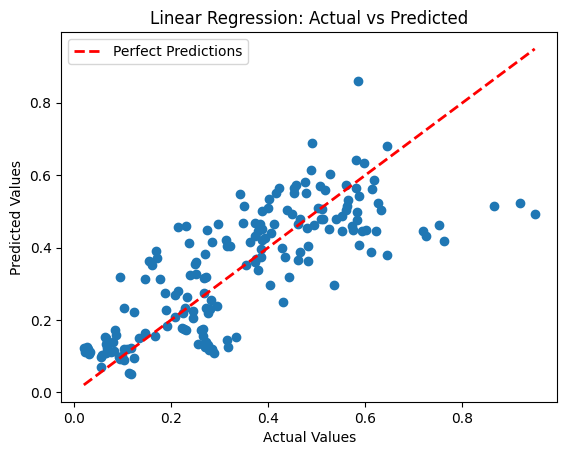

In [72]:
# Plot the actual vs predicted values
plt.scatter(y_valid, y_pred)
plt.plot([min(y_valid), max(y_valid)], [min(y_valid), max(y_valid)], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')
plt.title('Linear Regression: Actual vs Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()